<a href="https://colab.research.google.com/github/MScaramuzzi/A1-RNNs-for-Sequence-Labeling/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Due to**: 11/01/2022 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

**Authors**:

* Sergio Barezzani: sergio.barezzani@studio.unibo.it
* Giuseppe Morgese: giuseppe.morgese2@studio.unibo.it
* Marco Scaramuzzi: marco.scaramuzzi@studio.unibo.it

**Task**: given a corpus of documents, predict the POS tag for each word

**Corpus**: Ignore the numeric value in the third column, use only the words/symbols and its label. The corpus is available at: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

## Primari

1. Cambia codice getting dei files
    * Cambia struttura cartelle
2. One Hot Encoding + unk
    * Count OOV 

3. Evaluation
* History veloce
* Error analysis
 * Most frequent classifier
* Pad sequences
* Exclude padding from accuracy (?)
* F1 score confusion matrix

## Secondari

* Hyperparamter and refining
* Pad sequences
* Most frequent baseline


## Terziari
* History approfondita
* Better embedding 
* Plot migliori
* Tensorflow dataset
* LR Scheduler &rarr; StepLR 




Importing and installing useful libraries

In [25]:
!pip3 install keras_tuner
!pip install keras-tuner tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import urllib.request  #  download files
import tarfile  #  unzip files
import shutil
import os
import urllib.request  #  download files
import zipfile  #  unzip files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dropout, LSTM, Bidirectional, GRU, Dense, TimeDistributed, Activation,Masking
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


### Ensuring reproducibility

In [27]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [28]:
set_reproducibility(42)

## 1. Download the corpora and split it in training and test sets, structuring a dataframe.




**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.


**I/O structure**: The input data will have three dimensions: 1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

Dataset encoding explanation

#### Dataset downloading

In [29]:
data_folder = os.path.join(os.getcwd(), "Documents")

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(data_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("Documents")

docs_folder = os.path.join(data_folder, "dependency_treebank")

print("Successful extraction")

Successful download
Successful extraction


Changing the directory the the one of the data 

In [30]:
os.chdir(docs_folder)

In [31]:
# Retrieving file names
data = []

for filename in sorted(os.listdir(docs_folder)):
        data.append(filename)

train_files, val_files, test_files = data[0:100],data[100:150],data[150:200]
file_names = train_files+ val_files+ test_files

In [32]:
def unpack_dataset(files):
    X = []
    y = []
    for file in files:
        with open(file, mode="r", encoding="utf-8") as file_str:
            tokens = []
            tags = []
            for line in file_str.readlines():
                if line.strip() == "": # end of line retrieve 
                            X.append(np.array(tokens))
                            y.append(np.array(tags))
                            tokens = []
                            tags = []
                else:
                    # if the line is not empty, then we add the token to the sentence
                    token, tag, _ = line.split("\t")
                    tokens.append(token.lower())
                    tags.append(tag)
            X.append(np.array(tokens))
            y.append(np.array(tags))
    return np.array(X, dtype=object), np.array(y, dtype=object)


In [33]:
X_train_sents, y_train_tags = unpack_dataset(train_files)
X_val_sents, y_val_tags = unpack_dataset(val_files)
X_test_sents, y_test_tags = unpack_dataset(test_files)

### Dataframe creation

In [34]:
# Creating the structure of the dataframe rows
dataframe_rows = {
    'sentences': np.concatenate([X_train_sents, X_val_sents, X_test_sents],axis=0),
    'tags':np.concatenate([y_train_tags, y_val_tags, y_test_tags],axis=0) 
}

In [35]:
df = pd.DataFrame(dataframe_rows)
df.head(10)

,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,"[lorillard, inc., ,, the, unit, of, new, york-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,"[although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,"[a, lorillard, spokewoman, said, ,, ``, this, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,"[we, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,"[there, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


Dataframe inspection

In [36]:
print(f'Dataset shape: {df.shape} \n')

print(f'Dataset columns: {df.columns.values} \n')

print(f'Dataset Info: \n {df.info} \n')

print('Dataset Head: \n')
print("-"*50)
display(df.head())

Dataset shape: (3914, 2) 

Dataset columns: ['sentences' 'tags'] 

Dataset Info: 
 <bound method DataFrame.info of                                               sentences  \
0     [pierre, vinken, ,, 61, years, old, ,, will, j...   
1     [mr., vinken, is, chairman, of, elsevier, n.v....   
2     [rudolph, agnew, ,, 55, years, old, and, forme...   
3     [a, form, of, asbestos, once, used, to, make, ...   
4     [the, asbestos, fiber, ,, crocidolite, ,, is, ...   
...                                                 ...   
3909  [they, also, said, that, more, than, a, dozen,...   
3910  [sen., kennedy, said, in, a, separate, stateme...   
3911  [trinity, industries, inc., said, it, reached,...   
3912                   [terms, were, n't, disclosed, .]   
3913  [trinity, said, it, plans, to, begin, delivery...   

                                                   tags  
0     [NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...  
1     [NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...  
2 

,sentences,tags
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


### Data exploration
We now wish to understand the structure of the data before encoding it with the GloVe embedding and one-hot encoding the labels. 

We are going to perform some visualization of the distribution of the **tags** in order to make the error analysis, which will be done in the latter part of the notebook, more robust.

In [37]:
# Counting the sentences of each sets
print(f"- Sentences in the train set: {X_train_sents.shape[0]} sentences")
print(f"- Sentences in the validation set: {X_val_sents.shape[0]} sentences")
print(f"- Sentences in the test set: {X_test_sents.shape[0]} sentences")

- Sentences in the train set: 1963 sentences
- Sentences in the validation set: 1299 sentences
- Sentences in the test set: 652 sentences


In [38]:
print(f"Example structure of the arrays: \n {X_train_sents[0:5]} ")

Example structure of the arrays: 
 [array(['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join',
        'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.',
        '29', '.'], dtype='<U12')
 array(['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',',
        'the', 'dutch', 'publishing', 'group', '.'], dtype='<U10')
 array(['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former',
        'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',',
        'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this',
        'british', 'industrial', 'conglomerate', '.'], dtype='<U12')
 array(['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make',
        'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high',
        'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group',
        'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', '30',
        'years', 'ago', ',', 'researchers', 'reported', '.'], dtype='<U11')
 ar

The structure is an array (`X_train_sents`) of arrays. The elements of each subarray are the words in each sentence). 

In [39]:
print("Example of a document: ", ' '.join(X_val_sents[13]))
print("Example tags: ", (y_val_tags[13]))

Example of a document:  the potential sales are nearly $ 9.3 million , and house majority whip william gray -lrb- d. , pa . -rrb- began the bidding this year by proposing language that the quota be allocated to english-speaking countries of the caribbean , such as jamaica and barbados .
Example tags:  ['DT' 'JJ' 'NNS' 'VBP' 'RB' '$' 'CD' 'CD' ',' 'CC' 'NNP' 'NNP' 'NNP' 'NNP'
 'NNP' '-LRB-' 'NNP' ',' 'NNP' '.' '-RRB-' 'VBD' 'DT' 'NN' 'DT' 'NN' 'IN'
 'VBG' 'NN' 'IN' 'DT' 'NN' 'VB' 'VBN' 'TO' 'JJ' 'NNS' 'IN' 'DT' 'NNP' ','
 'JJ' 'IN' 'NNP' 'CC' 'NNP' '.']


From the above example we can see that in order to reduce the number of tokens in the OOV dictionaries we have lowercased every word. 

Later we will need to deal with removing ALL the tags that are non explicitly a word (so symbols, punctuation and **numbers**).

In [40]:
all_tags = np.concatenate(np.concatenate([y_train_tags,y_val_tags,y_test_tags])) # flatten tag subarrays
tags, counts = list(np.unique(all_tags, return_counts=True)) # count instances of each tag with return counts
tag_count= dict(zip(tags,counts)) # merge tags and counts in to a dictionary

print("The ten most frequent tags in the whole dataset are: ")
top_ten = dict(sorted(tag_count.items(), key=lambda item: item[1],reverse=True))
print(list(top_ten.items())[0:10])

The ten most frequent tags in the whole dataset are: 
[('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165), ('NNS', 6047), ('JJ', 5834), (',', 4886), ('.', 3874), ('CD', 3546), ('VBD', 3043)]


### Understanding content of tag arrays

We need to flatten each arrays with concatenate and then calculate the number of unique tags.

In [41]:
unique_tags_train= np.unique(np.concatenate(y_train_tags))
unique_tags_val = np.unique(np.concatenate(y_val_tags))
unique_tags_test = np.unique(np.concatenate(y_test_tags))

In [42]:
print(f"- Unique tags in train set: {len(unique_tags_train)} tags \n")
print(f"- Unique tags in validation set: {len(unique_tags_val)} tags \n")
print(f"- Unique tags in test set: {len(unique_tags_test)} tags")

- Unique tags in train set: 45 tags 

- Unique tags in validation set: 44 tags 

- Unique tags in test set: 40 tags


In [43]:
print("- Tags that are present in the train set and are not present in the validation set:",list(set(unique_tags_train).difference(set(unique_tags_val))))
print()
print("- Tags that are present in the train set and are not present in the test set:",list(set(unique_tags_train).difference(set(unique_tags_test))))
print()
print("- Tags that are present in the validation set and are not present in the test set:",list(set(unique_tags_val).difference(set(unique_tags_test))))

- Tags that are present in the train set and are not present in the validation set: ['SYM']

- Tags that are present in the train set and are not present in the test set: ['UH', 'FW', '#', 'SYM', 'LS']

- Tags that are present in the validation set and are not present in the test set: ['LS', 'FW', '#', 'UH']


### Retrieving punctuation indices 

This will be useful later for error analysis

Check cardinal numbers

In [44]:
sort_tags = np.array(sorted(unique_tags_train))

In [45]:
print(sort_tags)

['#' '$' "''" ',' '-LRB-' '-RRB-' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN'
 'JJ' 'JJR' 'JJS' 'LS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP'
 'PRP$' 'RB' 'RBR' 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP'
 'VBZ' 'WDT' 'WP' 'WP$' 'WRB' '``']


We need to the remove the indices associated with the following symbols:

* Punctuation:
  - -LRB- &rarr; "Left Round Bracket" &rarr; "({"
  - -RRB- &rarr; "Right Round Bracket" &rarr; "){"
  - # 
  - $
  - ' ' 
  - , 
  - . 
  - : 


* Symbols:

  - LS &rarr; List item marker
  - SYM &rarr; Symbol
  - ``

In [46]:
indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] # symbols and punctuation
print("Displaying the tags and their associated index: \n")
print(dict(zip(sort_tags[indices],indices)))

Displaying the tags and their associated index: 

{'#': 0, '$': 1, "''": 2, ',': 3, '-LRB-': 4, '-RRB-': 5, '.': 6, ':': 7, 'LS': 17, 'SYM': 31, '``': 44}


## Encoding the dataset


Generating embedding dictionary for GloVe 

In [47]:
# Download the GloVe embeddings
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe embeddings file
!unzip -q -o glove.6B.zip -d embeddings

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/Documents/dependency_treebank/Documents/dependency_treebank/glove.6B.zip
100% 862M/862M [02:39<00:00, 5.39MB/s]


We choose an embedding dimension of size 100d in order to have a good tradeoff between performance and time spent training.

It is also possible to experiment with other sizes such as 50,200 or 300. Through experimenting we have found that 100 is enough for our purposes.

In [48]:
""" 
Generating a dictionary of embeddings
where a word is a key and the value is the vector associated with an embedding
"""
V1 = {}
with open(docs_folder+"/embeddings/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        V1[word] = vector

### OOV handling

The OOV words will be assigned a random embedding sampled from uniform distribution, in the range `[-0.5,+0.5]` in order to match it with the numerical range of GloVe embeddings. It is also possible to experiment with other types of embedding for OOV.

In [49]:
embedding_dim = 100

In [50]:
def generate_oov(emb_dictionary, tokens,embedding_dim):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms
    """
    oov_dict = {} # create oov dict
    for token in tokens: 
        if token not in emb_dictionary:
            oov_dict[token]= np.random.uniform(-0.5, 0.5, size=embedding_dim)
    return oov_dict

In [51]:
# Flatten the arrays of each data split to get all tokens contained
train_toks = np.concatenate(np.concatenate([X_train_sents]))
val_toks = np.concatenate(np.concatenate([X_val_sents]))
test_toks = np.concatenate(np.concatenate([X_test_sents]))

In [52]:
# From the above flattened arrays retrieve the unique tags 
unique_train_toks = np.unique(train_toks)
unique_val_toks = np.unique(val_toks)
unique_test_toks = np.unique(test_toks)

In [53]:
max_size = 249

In [54]:
def encode_sentence(sentence,vocabulary):
    return np.array([vocabulary[word] for word in sentence])

In [67]:
def encode_features(array,vocabulary):
  result = []
  for sentence in array:
    pad_size = (250-len(sentence), embedding_dim)
    encoded = encode_sentence(sentence,vocabulary)
    result.append(
              np.row_stack((encoded, np.zeros(pad_size)))
            )
  return np.array(result,dtype=object)

In [68]:
print("Generating the OOV for train set... \n")
OOV1 = generate_oov(V1,unique_train_toks,embedding_dim)

print("Merging initial vocabulary and OOV1... \n")
V2 = {**V1,**OOV1}
X_train=encode_features(X_train_sents,V2)

print("Generating the OOV for validation set... \n")

OOV2 = generate_oov(V2,unique_val_toks,embedding_dim)
print("Merging V2 and OOV2: \n")
V3 = {**V2,**OOV2}
X_val=encode_features(X_val_sents,V3)

print("Generating the OOV for test set... \n")

OOV3 = generate_oov(V3,unique_test_toks,embedding_dim)

print("Merging V4 and OOV4... \n")

V4 = {**V3,**OOV3}
X_test=encode_features(X_test_sents,V4)


Generating the OOV for train set... 

Merging initial vocabulary and OOV1... 

Generating the OOV for validation set... 

Merging V2 and OOV2: 

Generating the OOV for test set... 

Merging V4 and OOV4... 



In [62]:
train_oov_terms = set(OOV1.keys())
val_oov_terms = set(OOV2.keys())
test_oov_terms = set(OOV3.keys())

In [63]:
seq_val_oov_terms = val_oov_terms - train_oov_terms
seq_test_oov_terms = test_oov_terms - train_oov_terms - val_oov_terms

In [64]:

print(
    f"Total training OOV terms: {len(train_oov_terms)} ({round(len(train_oov_terms) / len(unique_train_toks), 2)}%)"
)

print(
    f"Total validation OOV terms: {len(seq_val_oov_terms)} ({round(len(seq_val_oov_terms) / len(unique_val_toks), 2)}%)"
)
print(
    f"Total testing OOV terms: {len(seq_test_oov_terms)} ({round(len(seq_test_oov_terms) / len(unique_test_toks), 2)}%)"
)


Total training OOV terms: 359 (0.05%)
Total validation OOV terms: 189 (0.03%)
Total testing OOV terms: 128 (0.04%)


The percentage of OOV for each data split is negligible, still we can do better on composite and numbers.

In [65]:
print("- Train set OOV words:",list(OOV1.keys()))
print()
print("- Validation set OOV words:",list(OOV2.keys()))
print()
print("- Test set OOV words:",list(OOV3.keys()))

- Train set OOV words: ['-lcb-', '-lrb-', '-rcb-', '-rrb-', '1.457', '1.5755', '1.8415', '100,980', '11,762', '12,252', '127.03', '13,056', '14,821', '142.85', '143.08', '143.80', '143.93', '16,072', '16.125', '18,444', '1\\/10th', '1\\/2', '1\\/4', '2,303,328', '230-215', '234.4', '236.74', '236.79', '2645.90', '271,124', '278.7', '3,288,453', '3.253', '30,841', '3057', '352.7', '361,376', '37-a-share', '374.19', '374.20', '38.375', '382-37', '3\\/4', '4,393,237', '4.898', '415.6', '415.8', '436.01', '446.62', '449.04', '456.64', '497.34', '5.276', '500,004', '520-lawyer', '5\\/8', '62%-owned', '62.625', '69-point', '70-a-share', '705.6', '737.5', '7\\/8', '82,389', '8300s', '84-month', '9,118', '90-cent-an-hour', '95,142', 'abortion-related', 'ac-130u', 'achievement-test', 'akerfeldt', 'alurralde', 'amphobiles', 'anti-abortionists', 'anti-china', 'anti-takeover', 'antitrust-law', 'ariail', 'aslacton', 'asset-sale', 'autions', 'auto-safety', 'automotive-lighting', 'automotive-parts', 

###  One Hot Encoding of POS Tags


The task to the performed by the model is a multi-class classification therefore the labels are not encoded assigning integer values to each different class, but rather by one hot encoding.

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def encode_sentence(sentence,vocabulary):
    return np.array([vocabulary[word] for word in sentence])

In [ ]:
def encode_labels(array,vocabulary):
  result = []
  for sentence in array:
    pad_size = (250-len(sentence), embedding_dim)
    encoded = encode_sentence(sentence,vocabulary)
    result.append(
              np.row_stack((encoded, np.zeros(pad_size)))
            )
  return np.array(result,dtype=object)

In [136]:
ohe_arr = OneHotEncoder() # Get one hot encoding for POS tags in the training dataset

In [140]:
ohe_arr.fit_transform(np.array(unique_tags_train).reshape(-1, 1))

<45x45 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

One Hot encoding

Vocabularies for managing OOV words

### OOV Handling

In order to have a lower number of OOV words w.r.t. the embeddings that we will use next, we are going to perform a gentle preprocessing of each token.

1. to lower
2. encode numbers as ""
 * Number with "," or "."
 * Exclude CD from F1 score

# 3. Modeling




### Architectures used:
#### Baseline model
* Bidirectional LSMT + Dense layer 

#### Variations
* Bidirectional GRU + Dense layer
* Two Bidirectional LSMT + Dense layer
* Bidirectional LSMT + Two Dense layer

In [ ]:
n_classes = Y_train.shape[2]

In [ ]:
tfa_f1 = tfa.metrics.F1Score(
    num_classes= n_classes,
    name = 'f1_score',
    )

indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] 

def f1_with_tfa(y_true, y_pred):
    """
    Computes the F1 score using TensorFlow.
    The punctuation is ignored.
    """
    y_true = tf.reshape(y_true, (-1, n_classes))


    punctuation = tf.gather(y_true, indices, axis=-1)

    y_mask = tf.cast(tf.logical_not(tf.reduce_any( \
                    tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    
    tfa_f1.update_state(y_true, y_pred, sample_weight=y_mask)
    
    result = tfa_f1.result()
    
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in tfa_f1.variables])
    return K.sum(result)/(n_classes-len(indices))


## Baseline model

### Model 1: BILST with a Dense layer

In [ ]:
#epochs_tuning = 100
#batch_size_tuning = 64

In [ ]:
  # Define the model architecture
def BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

### Model 2: GRU

In [ ]:
# Create BiGRU and Dense layer
def BiGRU(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="gru_1")))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

### Model 3: Two BILSTM

In [ ]:
# Create model with two BiLSTM layers and Dense layer
def two_BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_2")))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

### Model 4: BILSTM + Dense Layer

In [ ]:
# Create model with one BiLSTM layers and two Dense layers
def bilstm_two_dense(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(TimeDistributed(Dense(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation="relu",name="dense_1")))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_2")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['categorical_accuracy',f1_with_tfa])
    return model

## 3.2 Hyperparameter tuning

### Model 1: BILST with a Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bilstm = RandomSearch(BiLSTM, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=3, overwrite=True)
tuner_bilstm.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print(f"\nHyper parameter tuning completed.\n" 
      f"=====================================\n"
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 3 Complete [00h 00m 51s]
val_f1_with_tfa: 0.0890439972281456

Best val_f1_with_tfa So Far: 0.4139796197414398
Total elapsed time: 00h 03m 13s

Hyper parameter tuning completed.
The optimal number of units in the LSTM layer is 256.
The optimal rate for Dropout layer is 0.5.
The optimal learning rate for the optimizer is 0.001.


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(tuner_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)

ValueError: ignored

### Model 2: Bidirectional GRU + Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bigru = RandomSearch(BiGRU, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=3, overwrite=True)
tuner_bigru.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 3 Complete [00h 00m 50s]
val_f1_with_tfa: 0.4137117862701416

Best val_f1_with_tfa So Far: 0.4458908140659332
Total elapsed time: 00h 03m 10s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 192.
The optimal rate for Dropout layer is 0.3.
The optimal learning rate for the optimizer is 0.001.


### Model 3:  Two Bidirectional LSMT + Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_two_bilstm = RandomSearch(two_BiLSTM, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=5, overwrite=True)
tuner_two_bilstm.search(X_train,Y_train, epochs=25, validation_data=(X_val, Y_val))

best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_two_bilstm.get('units')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 5 Complete [00h 03m 10s]
val_f1_with_tfa: 0.024915505200624466

Best val_f1_with_tfa So Far: 0.1657380908727646
Total elapsed time: 00h 17m 19s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 256.
The optimal number of units in the second LSTM layer is 256.
The optimal rate for the  Dropout layer is 0.2.
The optimal learning rate for the optimizer is 0.001.


### Model 4: Bidirectional LSMT + two Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bilstm_two_dense = RandomSearch(bilstm_two_dense, objective=Objective('val_f1_with_tfa', direction='max'), max_trials=3, overwrite=True)
tuner_bilstm_two_dense.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"\n Hyperparameter tuning done.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm_two_dense.get('units')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_bilstm_two_dense.get('units2')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm_two_dense.get('learning_rate')}.")

Trial 3 Complete [00h 00m 48s]
val_f1_with_tfa: 0.5273855328559875

Best val_f1_with_tfa So Far: 0.5273855328559875
Total elapsed time: 00h 03m 08s

 Hyperparameter tuning done.
The optimal number of units in the LSTM layer is 128.
The optimal number of units in the second LSTM layer is 64.
The optimal rate for Dropout layer is 0.2.
The optimal rate for the second Dropout layer is 0.0.
The optimal learning rate for the optimizer is 0.01.


##  3.3 Model training

### Model 1: Bidirectional LSMT + Dense layer 


In [ ]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode="max", restore_best_weights=True)]

In [ ]:
# Train the best model for 10 epochs
best_bilstm = tuner_bilstm.hypermodel.build(best_hps_bilstm)
best_bilstm.fit(X_train, Y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, Y_val),callbacks=callbacks_training)
best_bilstm.save('models/bilstm.h5')

Epoch 1/100
31/31 [==============================] - 12s 165ms/step - loss: 0.7341 - categorical_accuracy: 0.2312 - f1_with_tfa: 0.0341 - val_loss: 0.2730 - val_categorical_accuracy: 0.4074 - val_f1_with_tfa: 0.0670
Epoch 2/100
31/31 [==============================] - 2s 73ms/step - loss: 0.2139 - categorical_accuracy: 0.5008 - f1_with_tfa: 0.1479 - val_loss: 0.1673 - val_categorical_accuracy: 0.6185 - val_f1_with_tfa: 0.2732
Epoch 3/100
31/31 [==============================] - 2s 73ms/step - loss: 0.1503 - categorical_accuracy: 0.6606 - f1_with_tfa: 0.3078 - val_loss: 0.1385 - val_categorical_accuracy: 0.6872 - val_f1_with_tfa: 0.3481
Epoch 4/100
31/31 [==============================] - 2s 74ms/step - loss: 0.1276 - categorical_accuracy: 0.7264 - f1_with_tfa: 0.3770 - val_loss: 0.1223 - val_categorical_accuracy: 0.7441 - val_f1_with_tfa: 0.4175
Epoch 5/100
31/31 [==============================] - 2s 73ms/step - loss: 0.1164 - categorical_accuracy: 0.7564 - f1_with_tfa: 0.4125 - val_lo

### Model 2: Bidirectional GRU + Dense layer 



In [ ]:
# Train the best model for 10 epochs
best_bigru = tuner_bigru.hypermodel.build(best_hps_bigru)
best_bigru.fit(X_train, Y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, Y_val),callbacks=callbacks_training)
best_bigru.save('models/bigru.h5')

Epoch 1/100
31/31 [==============================] - 12s 168ms/step - loss: 0.6786 - categorical_accuracy: 0.4600 - f1_with_tfa: 0.1554 - val_loss: 0.1853 - val_categorical_accuracy: 0.6369 - val_f1_with_tfa: 0.2891
Epoch 2/100
31/31 [==============================] - 2s 76ms/step - loss: 0.1489 - categorical_accuracy: 0.7204 - f1_with_tfa: 0.3671 - val_loss: 0.1276 - val_categorical_accuracy: 0.7474 - val_f1_with_tfa: 0.4107
Epoch 3/100
31/31 [==============================] - 2s 79ms/step - loss: 0.1144 - categorical_accuracy: 0.7729 - f1_with_tfa: 0.4355 - val_loss: 0.1170 - val_categorical_accuracy: 0.7462 - val_f1_with_tfa: 0.4257
Epoch 4/100
31/31 [==============================] - 2s 78ms/step - loss: 0.1038 - categorical_accuracy: 0.7929 - f1_with_tfa: 0.4647 - val_loss: 0.1090 - val_categorical_accuracy: 0.7704 - val_f1_with_tfa: 0.4743
Epoch 5/100
31/31 [==============================] - 2s 78ms/step - loss: 0.0972 - categorical_accuracy: 0.8065 - f1_with_tfa: 0.4875 - val_lo

### Model 3:  Two Bidirectional LSMT + Dense layer 

In [ ]:
# Train the best model for 10 epochs
best_two_bilstm= tuner_two_bilstm.hypermodel.build(best_hps_two_bilstm)
best_two_bilstm.fit(X_train, Y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, Y_val),callbacks=callbacks_training)
best_two_bilstm.save('models/two_bilstm.h5')

### Model 4: Bidirectional LSMT + two Dense layer 

In [ ]:
# Train the best model for 10 epochs
best_bilstm_two_dense = tuner_bilstm_two_dense.hypermodel.build(best_hps_bilstm_two_dense)
best_bilstm_two_dense.fit(X_train, Y_train, epochs=epochs_training,batch_size=batch_size_training ,validation_data=(X_val, Y_val),callbacks=callbacks_training)
best_bilstm_two_dense.save('models/bilstm_two_dense.h5')

Epoch 1/100
31/31 [==============================] - 13s 192ms/step - loss: 0.7400 - categorical_accuracy: 0.1971 - f1_with_tfa: 0.0237 - val_loss: 0.3047 - val_categorical_accuracy: 0.3074 - val_f1_with_tfa: 0.0426
Epoch 2/100
31/31 [==============================] - 2s 77ms/step - loss: 0.2187 - categorical_accuracy: 0.4400 - f1_with_tfa: 0.0977 - val_loss: 0.1668 - val_categorical_accuracy: 0.5810 - val_f1_with_tfa: 0.2200
Epoch 3/100
31/31 [==============================] - 2s 76ms/step - loss: 0.1424 - categorical_accuracy: 0.6302 - f1_with_tfa: 0.2660 - val_loss: 0.1229 - val_categorical_accuracy: 0.6955 - val_f1_with_tfa: 0.3437
Epoch 4/100
31/31 [==============================] - 2s 80ms/step - loss: 0.1096 - categorical_accuracy: 0.7339 - f1_with_tfa: 0.3763 - val_loss: 0.1008 - val_categorical_accuracy: 0.7597 - val_f1_with_tfa: 0.4091
Epoch 5/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0947 - categorical_accuracy: 0.7703 - f1_with_tfa: 0.4204 - val_lo

In [ ]:
print(f"F1 score of BiLSTM model: {max(best_bilstm.history.history['val_f1_with_tfa'])}")
print(f"F1 score of BiGRU model:{max(best_bigru.history.history['val_f1_with_tfa'])}")
print(f"F1 score of BiLSTM two dense model:{max(best_bilstm_two_dense.history.history['val_f1_with_tfa'])}")


F1 score of BiLSTM model: 0.5786025524139404
F1 score of BiGRU model:0.6013060808181763
F1 score of BiLSTM two dense model:0.6533931493759155


In [ ]:
path_model_weights = os.path.join(os.getcwd(), 'models', 'weights')
path_model_weights

'/content/models/weights'

In [ ]:
# store models weights
#best_bilstm.save_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
best_bigru.save_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
best_bilstm_two_dense.save_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))


OSError: ignored

In [ ]:
path_model_structure = os.path.join(os.getcwd(), 'models', 'structure')
os.mkdir(path_model_structure)

2.3.2 Load all the pre-trained models

## History

In [ ]:
import matplotlib.pyplot as plt 



In [ ]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), y_scale="linear", figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.yscale(y_scale)

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="best",
          bbox_to_anchor=(1.0,0.6))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

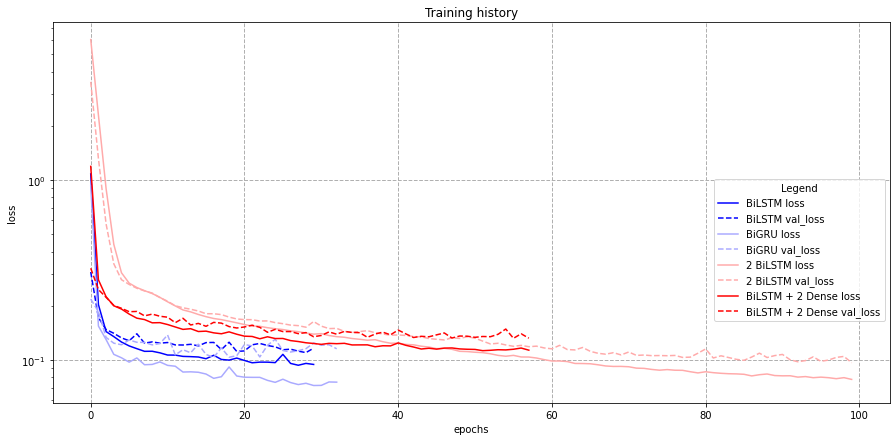

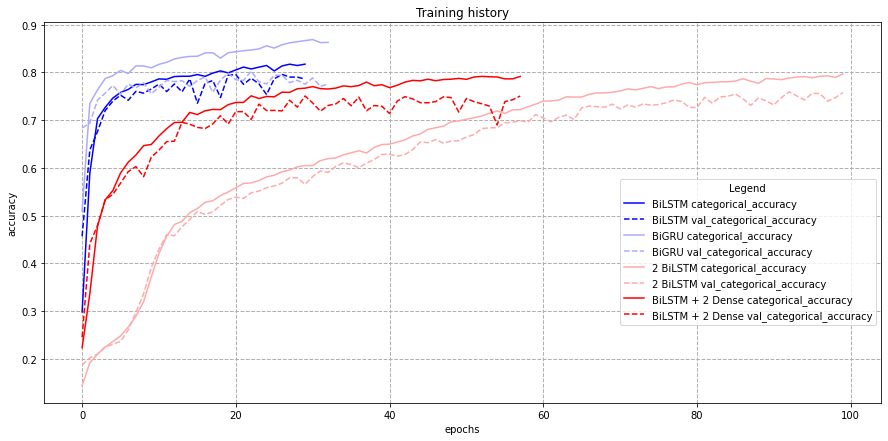

In [ ]:
models_history = [history_bilstm, history_bigru, history_two_bilstm, history_bilstm_two_dense]
model_names = ["BiLSTM", "BiGRU", "2 BiLSTM", "BiLSTM + 2 Dense"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), y_scale="log", figsize=(15,7),  cmap='bwr')
plot_history(models_history, keys=['categorical_accuracy', 'val_categorical_accuracy'], model_names=model_names, labels=("epochs", "accuracy"), figsize=(15,7),  cmap='bwr')


### Training

History of the training: leonidas

## Model Evaluation


In [ ]:
  # Select the two best models based on the validation ignore accuracy
  best_first_model = load_model('/content/models/bilstm_two_dense.h5',compile=False)

  best_second_model = load_model('/content/models/bigru.h5',compile=False)

  # Compile the models
  best_first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  best_second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(tuner_bilstm.get_best_models()[0], show_shapes=True, show_layer_names=True)


ValueError: ignored

In [ ]:
first_pred_labels = best_first_model.predict(X_test)
second_pred_labels = best_second_model.predict(X_test)

20/20 [==============================] - 3s 14ms/step


In [ ]:
  # Utilised functions
def modify_var(true, pred, indices):
    true = true.argmax(2)
    pred = pred.argmax(2)

    true_nopad = []
    pred_nopad = []

    for t, p in zip(true, pred):
        for i, el in enumerate(t):
            if el !=0 and el not in indices:
                true_nopad.append(el)
                pred_nopad.append(p[i])
    return true_nopad, pred_nopad

In [ ]:
no_punct = [sorted(unique_tags_train)[i] for i in range(len(unique_tags_train)) if not i in  indices]
no_punct

['CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

In [ ]:
def get_flattened_comparison(model, X_test, y_test):

    raw_y_pred = model.predict(X_test)

    # converting indexes to labels
    y_true_label = target_vectorizer.inverse_transform(y_test)
    y_pred_label = target_vectorizer.inverse_transform_probabilities(raw_y_pred)

    y_true_flat = []
    y_pred_flat = []
    for document_predicted, document_true in zip(y_pred_label, y_true_label):
        for word_predicted, word_true in zip (document_predicted, document_true):
            y_pred_flat.append(word_predicted)
            y_true_flat.append(word_true)
    return y_true_flat, y_pred_flat

In [ ]:
def show_classification_report(model, X_test, y_test, sorted_by=None, ascending=True):
  """
  Show classification report using only classes in names
  """
  y_true, y_pred = get_flattened_comparison(model, X_test, y_test)
  report =  classification_report(y_true, y_pred, output_dict=True, zero_division=0)
  
  # global performance
  keys = ['weighted avg', 'accuracy', 'macro avg']
  global_dict = {key: report[key] for key in keys}
  for key in keys:
    del report[key]

  df = pd.DataFrame.from_dict(report).transpose().round(2)
  if sorted_by:
    df.sort_values(by=sorted_by, ascending=ascending, inplace=True)
  print(df)

  print("\n\n")

  df_glob = pd.DataFrame.from_dict(global_dict).transpose().round(2)
  print(df_glob)

In [ ]:
def evaluate_model(model, X_test, y_test, labels):
    """
    given a trained model and a test set returns the f-score and the confusion matrix
    taking into account only classes in labels
    """
    # show confusion matrix
    y_true_flat, y_pred_flat = get_flattened_comparison(model, X_test, y_test)
    conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,14))
    disp.plot(ax=ax)
    # f1 score
    print("F1 score:\n-------------------------------")
    print(sklearn.metrics.f1_score(y_true_flat, y_pred_flat, labels=labels, average='macro', zero_division=0))

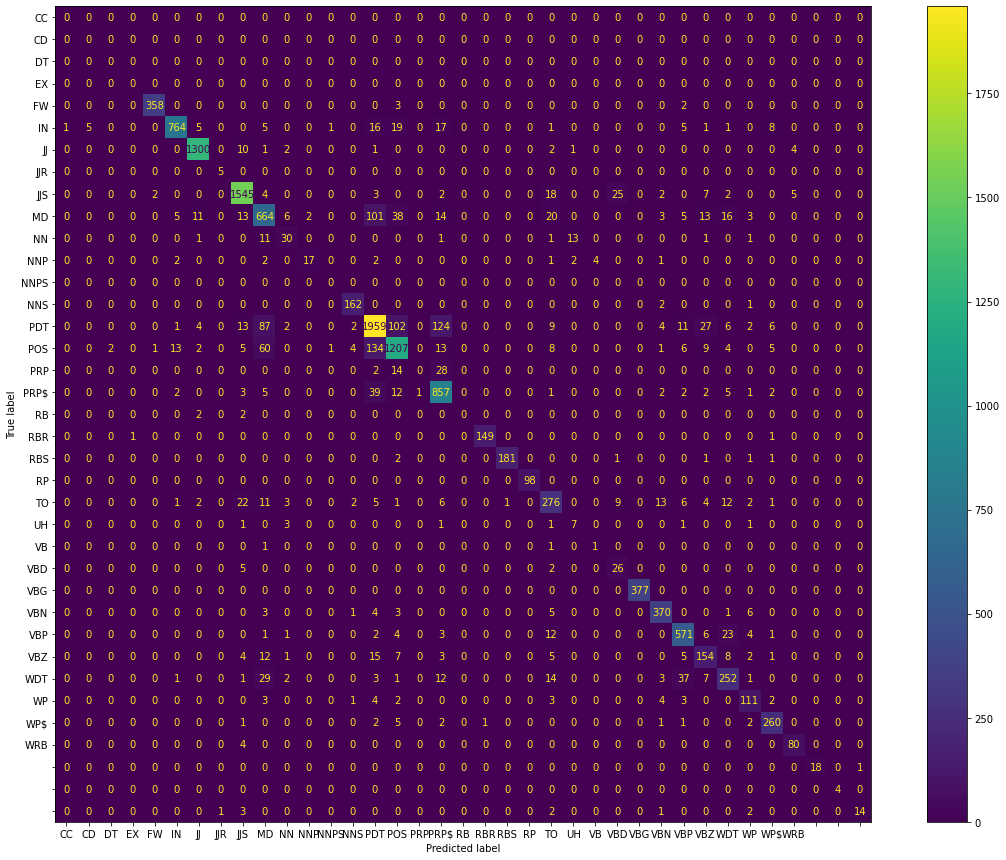

In [ ]:
true_var, pred_var = modify_var(Y_test, first_pred_labels, indices)
cm_one = confusion_matrix(true_var, pred_var)
display = ConfusionMatrixDisplay(confusion_matrix=cm_one, display_labels=no_punct)
#display_labels=[t for t, i in lab_dict.items() if i in list(set(Y_test.argmax(2).flatten()) - set(indices))]
fig, ax = plt.subplots(figsize=(20, 15))
display.plot(include_values=True, ax=ax)
plt.show()

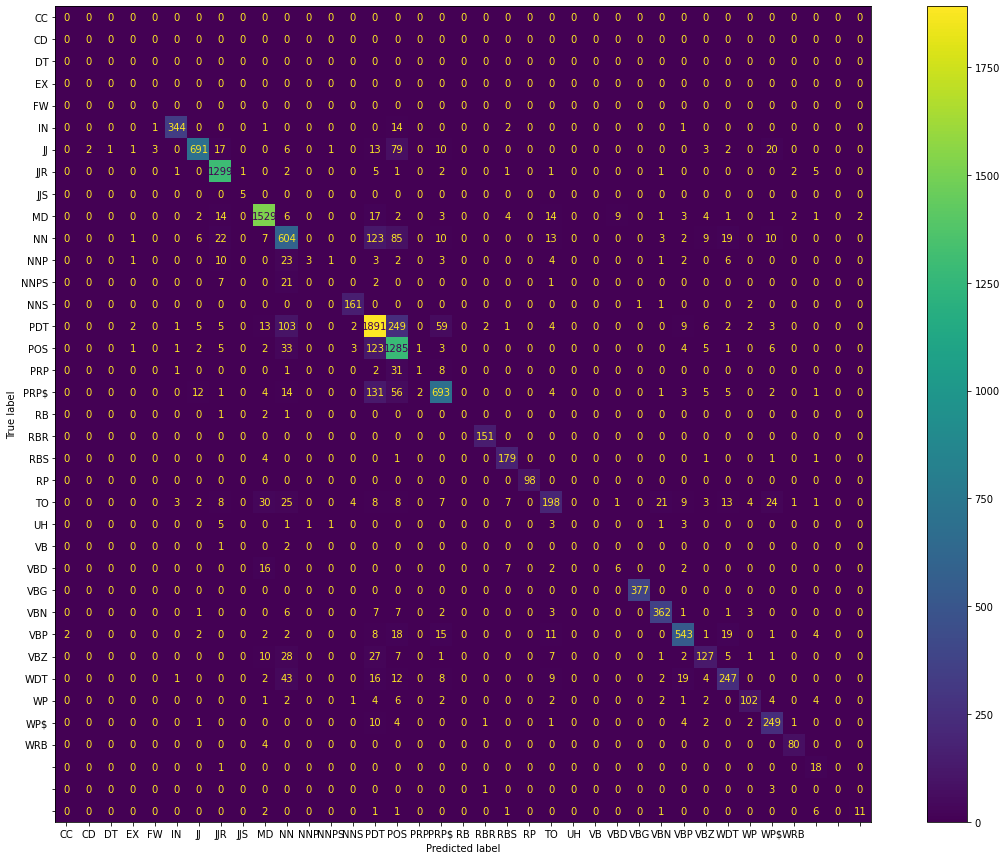

In [ ]:
true_var, pred_var = modify_var(Y_test, second_pred_labels, indices)
cm_one = confusion_matrix(true_var, pred_var)
display = ConfusionMatrixDisplay(confusion_matrix=cm_one, display_labels=no_punct)
#display_labels=[t for t, i in lab_dict.items() if i in list(set(Y_test.argmax(2).flatten()) - set(indices))]
fig, ax = plt.subplots(figsize=(20, 15))
display.plot(include_values=True, ax=ax)
plt.show()

1.   show_classification_report
2.   Voce elenco



In [ ]:
# Calculate the F1 macro score
true_nopad, first_pred_nopad = modify_var(Y_test, first_pred_labels, indices)
true_nopad, second_pred_nopad = modify_var(Y_test, second_pred_labels, indices)
first_f1_macro = f1_score(true_nopad, first_pred_nopad, average='macro', zero_division=1)
second_f1_macro = f1_score(true_nopad, second_pred_nopad, average='macro', zero_division=1)

# Print the performance of the models
print('Best Models Performance')
print(f'\nFirst F1 Macro: {round(first_f1_macro, 3)}')
print(f'\nSecond F1 Macro: {round(second_f1_macro, 3)}')
     

Best Models Performance

First F1 Macro: 0.667

Second F1 Macro: 0.554


## Final Error analysis

 the performances on the most frequent classes and the less frequent classes, precision and recall, the confusion tables, specific misclassified samples.

Result examples of BiLSTM model

In [ ]:

i_test = 10  # change this to see the prediction for a different sentence
print("Original sentence: ", X_test_sentences[i_test])
print("Original POS tagging: ",target_vectorizer.inverse_transform([y_test[i_test]])[0])

raw_y_pred = model_bilstm.predict(np.array([X_test[i_test]]))

print("Predicted POS tagging: ",target_vectorizer.inverse_transform_probabilities(raw_y_pred)[0])

* verify and discuss if the results on the test sets are coherent with those on the validation set

* analyze the errors done by your model 


* try to understand which may be the causes and think about how to improve it.